In [3]:
# Install requirements
! pip install keras
! pip install git+https://github.com/nottombrown/imagenet_stubs --upgrade

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-zu9pcpqi
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-zu9pcpqi
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794798 sha256=73504009882d53cbb249c607d773369492bacba6284f447d0ba4d93d8ea9bed0
  Stored in directory: /tmp/pip-ephem-wheel-cache-af4yu9og/wheels/48/52/bf/2bca833fe1e709dbd0a32a322e7dda02cd17c6c8ebf5127949
Successfully built imagenet-stubs


In [25]:
import torch
import torchvision.models as models
import numpy as np
import os
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name
import matplotlib.pyplot as plt
import PIL.Image
import random

## Hyperparameters

In [39]:

# Example usage
TARGET_LABEL = name_to_label('toaster')  # Replace 'toaster' with your desired target

# Adjusting patch shape for PyTorch (channels first)
PATCH_SHAPE = (3, 299, 299)
BATCH_SIZE = 16

# Ensemble of models
NAME_TO_MODEL = {
    'densenet121': models.densenet121,
    'vgg16': models.vgg16,
    'vgg19': models.vgg19,
    'resnet50': models.resnet50,
    'inceptionv3': models.inception_v3,
}

MODEL_NAMES = ['resnet50',  'vgg16', 'vgg19', 'densenet121']

# Data augmentation parameters
SCALE_MIN = 0.3
SCALE_MAX = 1.5
ROTATE_MAX = np.pi / 8  # 22.5 degrees

MAX_ROTATION = 22.5

# Local data dir to write files to
DATA_DIR = '/content/adversarial_patch'

## Image loading

Example true image:


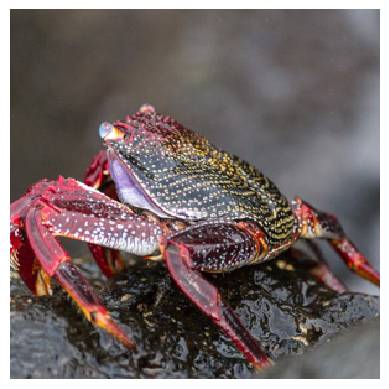

Example true image:


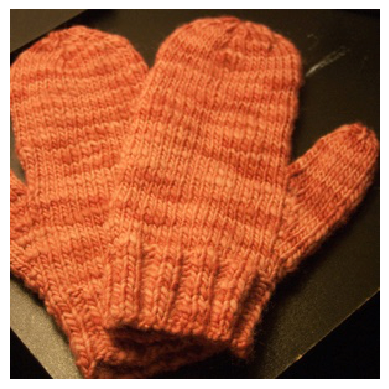

In [13]:
def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.show()
  
def load_image(image_path):
  im = PIL.Image.open(image_path)
  im = im.resize((299, 299), PIL.Image.ANTIALIAS)
  if image_path.endswith('.png'):
    ch = 4
  else:
    ch = 3
  im = np.array(im.getdata()).reshape(im.size[0], im.size[1], ch)[:,:,:3]
  return im / 127.5 - 1


class StubImageLoader():
  """An image loader that uses just a few ImageNet-like images. 
  In the actual paper, we used real ImageNet images, but we can't include them 
  here because of licensing issues.
  """
  def __init__(self):
    self.images = []
    self.toaster_image = None
   
    for image_path in imagenet_stubs.get_image_paths():
      im = load_image(image_path)

      if image_path.endswith('toaster.jpg'):
        self.toaster_image = im
      else:
        self.images.append(im)

  def get_images(self):
    return random.sample(self.images, BATCH_SIZE)

image_loader = StubImageLoader()

for example_image in image_loader.get_images()[:2]:
  print("Example true image:")
  show(example_image)
  

## Patch Transformations

Test image with random transform: 1


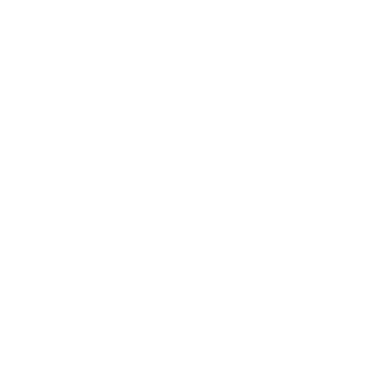

Test image with random transform: 2


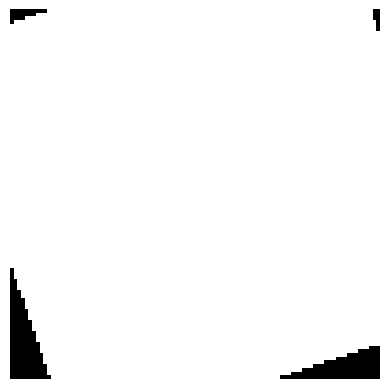

In [18]:
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

def _transform_vector(width, x_shift, y_shift, im_scale, rot_in_degrees):
    rot = float(rot_in_degrees) * (math.pi / 180.0)

    # Rotation matrix
    rot_matrix = np.array([
        [math.cos(rot), -math.sin(rot)],
        [math.sin(rot), math.cos(rot)]
    ])

    # Inverse scale
    inv_scale = 1.0 / im_scale
    xform_matrix = rot_matrix * inv_scale

    # Center of the image
    x_origin = float(width) / 2
    y_origin = float(width) / 2

    # Transformed center
    x_origin_shifted, y_origin_shifted = np.matmul(xform_matrix, np.array([x_origin, y_origin]))

    # Shifts
    x_origin_delta = x_origin - x_origin_shifted
    y_origin_delta = y_origin - y_origin_shifted

    # Final translation
    a2 = x_origin_delta - (x_shift / (2 * im_scale))
    b2 = y_origin_delta - (y_shift / (2 * im_scale))

    # Affine matrix for PyTorch (2x3 matrix)
    return np.array([[xform_matrix[0][0], xform_matrix[0][1], a2],
                     [xform_matrix[1][0], xform_matrix[1][1], b2]]).astype(np.float32)

def test_random_transform(min_scale=0.5, max_scale=1.0, max_rotation=22.5):
    img_shape = (3, 100, 100)
    img = torch.ones(img_shape, dtype=torch.float32)

    # Random transformation
    im_scale = np.random.uniform(low=min_scale, high=max_scale)
    padding_after_scaling = (1 - im_scale) * img_shape[1]
    x_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
    y_delta = np.random.uniform(-padding_after_scaling, padding_after_scaling)
    rot = np.random.uniform(-max_rotation, max_rotation)

    transform_matrix = _transform_vector(img_shape[1], x_delta, y_delta, im_scale, rot)

    # Apply affine transformation
    affine_transformation = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Lambda(lambda x: x.transform(x.size, PIL.Image.AFFINE, transform_matrix.flatten(), resample=PIL.Image.BILINEAR)),
        transforms.ToTensor()
    ])

    transformed_img = affine_transformation(img)
    return transformed_img

def show(tensor_img):
    plt.imshow(tensor_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Testing the transformations
for i in range(2):
    print("Test image with random transform: {}".format(i + 1))
    transformed_img = test_random_transform(min_scale=0.25, max_scale=2.0, max_rotation=22.5)
    show(transformed_img)


## ModelState

This code handles loading different Imagenet models, running them, and storing their state.

It defines `M`, a `ModelState` instance.

### Available models:
* xception
* vgg16
* vgg19
* resnet50
* inceptionv3
* mobilenet

## API

### `M.load_model(model_name)` 
### `M.patch(new_patch)`
### `M.patch()`
### `M.reset_patch()`
### `M.train_step(images?, target_ys?, learning_rate?)`
### `M.inference_batch(images?, target_ys?)`


### masks

In [21]:
#@title class ModelState()

def get_peace_mask(shape):
  path = os.join(DATA_DIR, "peace_sign.png")
  pic = PIL.Image.open(path)
  pic = pic.resize(shape[:2], PIL.Image.ANTIALIAS)
  if path.endswith('.png'):
    ch = 4
  else:
    ch = 3
  pic = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], ch)
  pic = pic / 127.5 - 1
  pic = pic[:,:,3]

  peace_mask = (pic + 1.0) / 2
  peace_mask = np.expand_dims(peace_mask, 2)
  peace_mask = np.broadcast_to(peace_mask, shape)
  return peace_mask


def _circle_mask(shape, sharpness = 40):
  """Return a circular mask of a given shape"""
  assert shape[0] == shape[1], "circle_mask received a bad shape: " + shape

  diameter = shape[0]  
  x = np.linspace(-1, 1, diameter)
  y = np.linspace(-1, 1, diameter)
  xx, yy = np.meshgrid(x, y, sparse=True)
  z = (xx**2 + yy**2) ** sharpness

  mask = 1 - np.clip(z, -1, 1)
  mask = np.expand_dims(mask, axis=2)
  mask = np.broadcast_to(mask, shape).astype(np.float32)
  return mask

def _gen_target_ys():
  label = TARGET_LABEL
  y_one_hot = np.zeros(1000)
  y_one_hot[label] = 1.0
  y_one_hot = np.tile(y_one_hot, (BATCH_SIZE, 1))
  return y_one_hot

TARGET_ONEHOT = _gen_target_ys()

In [ ]:
### Model Container

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
class ModelContainer:
    """Encapsulates an Imagenet model, and methods for interacting with it in PyTorch."""

    def __init__(self, model_name, verbose=True, peace_mask=None, peace_mask_overlay=0.0):
        self.model_name = model_name
        self.peace_mask = peace_mask
        self.patch_shape = PATCH_SHAPE  # Define PATCH_SHAPE as per your requirement
        self._peace_mask_overlay = peace_mask_overlay
        self.patch_data = torch.zeros(self.patch_shape)
        self.load_model(verbose=verbose)

    def patch(self, new_patch=None):
        """Retrieve or set the adversarial patch."""
        if new_patch is None:
            return self.patch_data
        self.patch_data = new_patch
        return self

    def reset_patch(self):
        """Reset the adversarial patch to all zeros."""
        self.patch(torch.zeros(self.patch_shape))

    def train_step(self, images, target_ys, learning_rate=5.0, scale=(0.1, 1.0), dropout=None, patch_disguise=None, disguise_alpha=None):
        """Train the model for one step."""
        self.model.train()  # Set the model to training mode

        # Apply adversarial patch to images here (not implemented)

        # Assuming images and target_ys are PyTorch tensors
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        optimizer.zero_grad()
        outputs = self.model(images)
        loss = criterion(outputs, target_ys)
        loss.backward()
        optimizer.step()

        return loss.item()

    def inference_batch(self, images, target_ys=None, scale=None):
        """Report loss and label probabilities, and patched images for a batch."""
        self.model.eval()  # Set the model to evaluation mode

        # Apply adversarial patch to images here (not implemented)

        with torch.no_grad():
            outputs = self.model(images)
            probabilities = nn.functional.softmax(outputs, dim=1)
            loss_per_example = None

            if target_ys is not None:
                criterion = nn.CrossEntropyLoss(reduction='none')
                loss_per_example = criterion(outputs, target_ys)

        return loss_per_example, probabilities, images

    def load_model(self, verbose=True):
        """Load the specified PyTorch model."""
        model = torch.hub.load('pytorch/vision:v0.10.0', self.model_name, pretrained=True)
        self.model = model.eval()  # Set the model to evaluation mode
        if verbose:
            print(f"Model {self.model_name} loaded.")


    # def load_model(self, verbose=True):
    #     """Load the specified PyTorch model."""
    #     if self.model_name.lower() == 'inceptionv3':
    #         self.model = models.inception_v3(pretrained=True)
    #     # Add other models here as elif conditions
    #     else:
    #         model = torch.hub.load('pytorch/vision:v0.10.0', self.model_name, pretrained=True)
    #         self.model = model.eval() 
    #         raise ValueError(f"Model {self.model_name} not recognized.")

    #     self.model.eval()  # Set the model to evaluation mode
    #     if verbose:
    #         print(f"Model {self.model_name} loaded.")
    
    def _make_model_and_ops(self, model_class, pretrained=True, verbose=True):
        start = time.time()

        # Load the model
        self.model = model_class(pretrained=pretrained)

        # Define loss functions and optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters())

        elapsed = time.time() - start
        if verbose:
            print("Finished loading model, took {:.0f}s".format(elapsed))

    def _pad_and_tile_patch(self, patch, image_shape):
        # Example of padding and tiling a patch in PyTorch
        # Note: This is a simplified example. You will need to adjust this based on your specific requirements
        batch_size = 32  # Example batch size
        return patch.repeat(batch_size, 1, 1, 1)

    def _random_overlay(self, imgs, patch, image_shape):
        # Apply random transformations to the patch and overlay it on the images
        # This is a placeholder implementation. You need to adapt it to your specific use case
        transformed_patch = transforms.functional.affine(patch, angle=0, translate=(0, 0), scale=1.0, shear=0)
        return imgs + transformed_patch

In [ ]:
import numpy as np

class MetaModel:
    def __init__(self, verbose=True, peace_mask=None, peace_mask_overlay=0.0):
        self.nc = {m: ModelContainer(m, verbose=verbose, peace_mask=peace_mask, peace_mask_overlay=peace_mask_overlay) for m in MODEL_NAMES}
        self._patch = np.zeros(PATCH_SHAPE)
        self.patch_shape = PATCH_SHAPE

    def patch(self, new_patch=None):
        """Retrieve or set the adversarial patch."""
        if new_patch is None:
            return self._patch

        self._patch = new_patch
        for model_container in self.nc.values():
            model_container.patch(new_patch)
        return self

    def reset_patch(self):
        """Reset the adversarial patch to all zeros."""
        self.patch(np.zeros(self.patch_shape))

    def train_step(self, model=None, steps=1, images=None, target_ys=None, learning_rate=5.0, scale=None, **kwargs):
        """Train the model for `steps` steps."""
        if model is not None:
            to_train = [self.nc[model]]
        else:
            to_train = self.nc.values()

        losses = []
        for mc in to_train:
            for _ in range(steps):
                loss = mc.train_step(images, target_ys, learning_rate, scale=scale, **kwargs)
                losses.append(loss)
        return np.mean(losses)

    def inference_batch(self, model, images=None, target_ys=None, scale=None):
        """Report loss and label probabilities, and patched images for a batch."""
        mc = self.nc[model]
        return mc.inference_batch(images, target_ys, scale=scale)

# Example usage
print("Creating MetaModel...")
MM = MetaModel()


In [41]:
## Displaying Utils

In [42]:
def _convert(im):
  return ((im + 1) * 127.5).astype(np.uint8)

def show(im):
  plt.axis('off')
  plt.imshow(_convert(im), interpolation="nearest")
  plt.show()
 
def show_patch(patch):
  circle = _circle_mask((299, 299, 3))
  show(circle * patch + (1-circle))

def report(model, step=None, show_images=False, n=400, verbose=True, scale=(0.1, 1.0)):
  """Prints a report on how well the model is doing.
  If you want to see multiple samples, pass a positive int to show_images

  Model can be a ModelContainer instance, or a string. If it's a string, we
  lookup that model name in the MultiModel
  """
  start = time.time()
  # n examples where target was in top 5
  top_5 = 0
  # n examples where target was top 1
  wins = 0
  # n examples in total
  n_batches = int(math.ceil(float(n) / BATCH_SIZE))
  total = BATCH_SIZE * n_batches

  loss = 0

  for b in range(n_batches):
    if isinstance(model, str):
      loss_per_example, probs, patched_imgs = M.inference_batch(model, scale=scale)
    else:
      loss_per_example, probs, patched_imgs = model.inference_batch(scale=scale)

    loss += np.mean(loss_per_example)
    for i in range(BATCH_SIZE):
      top_labels = np.argsort(-probs[i])[:5]
      if TARGET_LABEL in top_labels:
        top_5 += 1
        if top_labels[0] == TARGET_LABEL:
          wins += 1
  loss = loss / n_batches
  top_5p = int(100 * float(top_5) / total)
  winp = int(100 * float(wins) / total)

  if step is not None:
    r = 'Step: {} \t'.format(step)
  else:
    r = ''
  r += 'LogLoss: {:.1f} \tWin Rate: {}%\t Top5: {}%\tn: {}'.format(math.log(loss), winp, top_5p, total)
  if verbose:
    print(r)

  if show_images:
    if show_images is True:
      show_images = 1
    _visualize_example(patched_imgs, probs, loss_per_example, show_images)
  elapsed = time.time() - start
  return {'logloss': math.log(loss), 'win': winp, 'top5': top_5p, 'time': elapsed, 'loss': loss}

def _visualize_example(patched_imgs, probs, loss_per_example, n_reports=1):
  for i in range(n_reports):
    show(patched_imgs[i])

    predictions_str = ''
    top_label_ids = np.argsort(-probs[i])[:5]
    for label in top_label_ids:
      p = probs[i][label]
      name = label_to_name(label)
      if len(name) > 30:
        name = name[:27] + "..."
      if name == "toaster":
        predictions_str += "\033[1m"
      name = name.ljust(30, " ")
      predictions_str += "{} {:.2f}".format(name, p)
      if name.startswith("toaster"):
        predictions_str += "\033[0m"
      predictions_str += "\n"
    #predictions_str += "\033[1mLogLoss: {:.1f}\033[0m\n".format(math.log(loss_per_example[i]))

    print(predictions_str)


def cross_model_report(meta_model, n=100, verbose=True, scale=None):
  results = {}

  print('{:15s}\t Loss\t Win%\t Top5%\t Time'.format('Model Name'))

  out_start = time.time()
  for model_name in MODEL_NAMES:
    model = meta_model.name_to_container[model_name]
    r = report(model, n=n, verbose=False, scale=scale)
    results[model_name] = r
    print('{:15s}\t {:.1f}\t {:.0f}%\t {:.0f}%\t {:.0f}s'.format(model_name, r['loss'], r['win'], r['top5'], r['time']))

  def _avg(name):
    xs = [r[name] for r in results.values()]
    return sum(xs) / len(xs)


  elapsed = time.time() - out_start
  print('{:15s}\t {:.1f}\t {:.0f}%\t {:.0f}%\t {:.0f}s'.format('Average/Total', _avg('loss'), _avg('win'), _avg('top5'), elapsed))

  return results

Creating MetaModel...


Using cache found in /home/yo46/.cache/torch/hub/pytorch_vision_v0.10.0


Model resnet50 loaded.


Using cache found in /home/yo46/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yo46/anaconda3/envs/llmattack/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/yo46/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 209MB/s]  


Model vgg16 loaded.


Using cache found in /home/yo46/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yo46/anaconda3/envs/llmattack/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/yo46/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 212MB/s]  


Model vgg19 loaded.


Using cache found in /home/yo46/.cache/torch/hub/pytorch_vision_v0.10.0
/home/yo46/anaconda3/envs/llmattack/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/yo46/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 144MB/s] 


Model densenet121 loaded.
